<a href="https://colab.research.google.com/github/Evanyl/screw-sorter-sw/blob/gking%2F4%2Ftraining_pipeline/screw_sorter_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# NN imports
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from tensorflow.keras import regularizers
from tensorflow.keras.losses  import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
# Data processing imports
from sklearn.model_selection import cross_val_score, \
                                    cross_validate,  \
                                    train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# General imports
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import json
import re
import sys

# Make a shortcut to '2357 Screw Sorter' folder on your personal drive
DATA_DIR = "/content/drive/MyDrive/2357 Screw Sorter/Data Clean/"

In [2]:
#                 C L A S S I F I C A T I O N    P L A N
#
# predict on 5 output classes: head, drive, thread, length, width
#
# additional binary measurement system classifier
#
# width:  regression classifier [input binarized cropped images + coordinates of cropping]
# length: regression classifier [input binarized cropped images + coordinates of cropping]
# pitch:  regression classifier [input binarized cropped dft + coordinates of cropping]
# head:   discrete classifier   [input binarized cropped image]
# drive:  discrete classifier   [input side-on cropped image]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Import

In [4]:
INCH_TO_MM = 25.4

num2inchwidth = [
    0.060, # No.0
    0.073, # No.1
    0.086, # No.2
    0.099, # No.3
    0.112, # No.4
    0.125, # No.5
]

def sfrac2float(s):
  """
  in:  str fraction "{num}/{denom}"
  out: float
  """
  nums = s.split("/")
  return int(nums[0]) / int(nums[1])

def processMetric(label):
  """
  in:  metric label dict
  out: unified metric label dict
  """
  w = float(label["thread_size"].split("M")[-1])
  l = float(label["length"].split("mm")[0])
  p = float(label["thread_pitch"].split("mm")[0])
  return {"width": w, "length": l, "pitch": p, "metric": True}

def processImperial(label):
  """
  in:  imperial label dict
  out: unified metric label dict
  """
  thread_size = label["thread_size"].split("-")
  w = num2inchwidth[int(thread_size[0])]*INCH_TO_MM
  l = sfrac2float(label["length"].split('"')[0])*INCH_TO_MM
  p = 1.0/int(thread_size[1])*INCH_TO_MM
  return {"width": w, "length": l, "pitch": p, "metric": False}


In [5]:
data_frames = []
THRESH = 150

home = os.getcwd()
os.chdir(DATA_DIR)
data_directories = [f for f in os.listdir(DATA_DIR) if os.path.isdir(f)]
count = 0
for data_directory in data_directories:
  os.chdir(data_directory)
  metadata_file = [f for f in os.listdir() if not os.path.isdir(f)][0]
  with open(metadata_file) as mf:

    metadata = json.load(mf)
    label = {}

    if re.match("M", metadata["thread_size"]):
      label = processMetric(metadata)
    else:
      label = processImperial(metadata)

    image_directories = [f for f in os.listdir() if os.path.isdir(f)]
    for image_directory in image_directories:
      os.chdir(image_directory)
      image_files = os.listdir()
      for image_file in image_files:
        if re.match(".*_top", image_file):
          count += 1
          img = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
          grey = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
          ret,thresh = cv2.threshold(grey,THRESH,255,cv2.THRESH_BINARY)
          data_frames.append(pd.DataFrame({**label,**{"top-down":[thresh]}}, index=[data_directory]))
  os.chdir(DATA_DIR)
os.chdir(home)
label_set_persistent = pd.concat(data_frames)
label_set_persistent.head()

,width,length,pitch,metric,top-down
92210A081,2.1844,12.7000,0.453571,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92949A899,2.5146,7.9375,0.529167,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92000A013,2.0000,6.0000,0.400000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92125A058,2.0000,12.0000,0.400000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
92125A126,3.0000,6.0000,0.500000,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# Visualize Labels



<Axes: xlabel='length'>

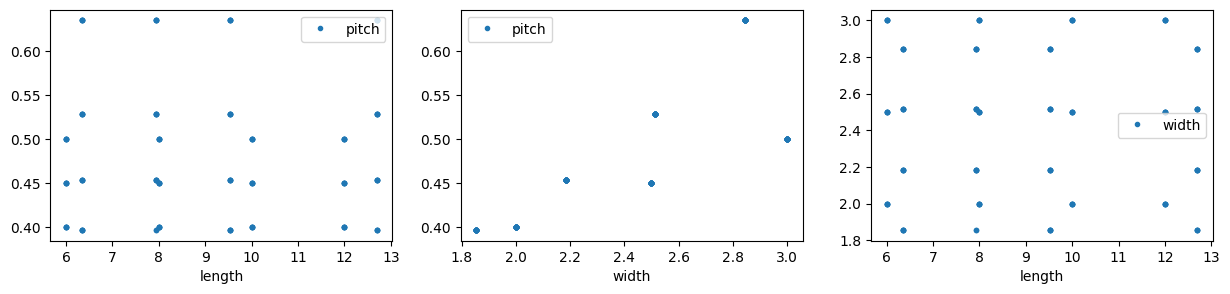

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3)

label_set_persistent.plot(x="length", y="pitch", style=".", ax=axes[0])
label_set_persistent.plot(x="width", y="pitch", style=".", ax=axes[1])
label_set_persistent.plot(x="length", y="width", style=".", ax=axes[2], figsize=(15,3))

In [ ]:
print("Unique pitches: {l}".format(l=list(label_set_persistent["pitch"].unique())))
print("Unique widths:  {l}".format(l=list(label_set_persistent["width"].unique())))
print("Unique lengths: {l}".format(l=list(label_set_persistent["length"].unique())))

# Image Data Processing

In [8]:
from cv2.typing import Vec3f
def _get_center(contours, x, y, vx, vy):
  err1 = sys.float_info.max
  err2 = sys.float_info.max
  p1 = (0,0)
  p2 = (0,0)
  m = -vy[0]/vx[0]
  p0_x = x[0]
  p0_y = y[0]

  for c in contours:
    p_x = c[0][0]
    p_y = c[0][1]
    if abs(-(p0_y-p_y)/(p0_x-p_x) - m) < err1 and p_x < p0_x:
      err1 = abs(-(p0_y-p_y)/(p0_x-p_x) - m)
      p1 = (p_x,p_y)
    if abs(-(p_y-p0_y)/(p_x-p0_x) - m) < err2 and p_x > p0_x:
      err2 = abs(-(p_y-p0_y)/(p_x-p0_x) - m)
      p2 = (p_x,p_y)

  return (int((p2[0] + p1[0])/2), int((p2[1] + p1[1])/2))

def _adjust_vec(vx, vy, x_center, y_center, x_centroid, y_centroid):
  vec = None
  m = -vy/vx

  if   ((m >= 1/2 and m >= 0) and (y_center >= y_centroid)) or \
       ((m < 1/2 and m >= 0) and (x_center <= x_centroid)):
       # Quadrant 1
       vec = (abs(vx), abs(vy))
  elif ((m <= -1/2 and m <= 0) and (y_center >= y_centroid)) or \
       ((m > -1/2 and m <= 0) and (x_center >= x_centroid)):
       # Quadrant 2
       vec = (-abs(vx), abs(vy))
  elif ((m <= 1/2 and m >= 0) and (x_center >= x_centroid)) or \
       ((m > 1/2 and m >= 0) and (y_center <= y_centroid)):
       # Quadrant 3
       vec = (-abs(vx), -abs(vy))
  elif ((m <= -1/2 and m <= 0) and (y_center <= y_centroid)) or \
       ((m > -1/2 and m <= 0) and (x_center <= x_centroid)):
       # Quadrant 4
       vec = (abs(vx), -abs(vy))
  return vec

def _normalize_direction(vx, vy, x_center, y_center, x_centroid, y_centroid, theta_curr):
  theta_correction  = 0.0
  m = -vy/vx

  if   ((m >= 1/2 and m >= 0) and (y_center >= y_centroid)) or \
       ((m <=  1/2 and m >= 0) and (x_center <= x_centroid)):
       # Quadrant 1
       theta_correction = -theta_curr
  elif ((m <= -1/2 and m <= 0) and (y_center >= y_centroid)) or \
       ((m >=  -1/2 and m <= 0) and (x_center >= x_centroid)):
       # Quadrant 2
       theta_correction = -theta_curr
  elif ((m <= 1/2 and m >= 0) and (x_center >= x_centroid)) or \
       ((m >=  1/2 and m >= 0) and (y_center <= y_centroid)):
       # Quadrant 3
       theta_correction = theta_curr
  elif ((m <= -1/2 and m <= 0) and (y_center <= y_centroid)) or \
       ((m >=  -1/2 and m <= 0) and (x_center <= x_centroid)):
       # Quadrant 4
       theta_correction = theta_curr
  return theta_correction

def _straighten(image, center, theta):
   """
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   """
   shape = (image.shape[1], image.shape[0])
   matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)
   return cv2.warpAffine(src=image, M=matrix, dsize=shape)

def _crop(img):
  contours,_ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
  contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
  x,y,w,h = cv2.boundingRect(contours_sorted[1])
  return [img[y:y+h,x:x+w]]

class AlignCropTransformer(BaseEstimator, TransformerMixin):
  """
  Column transformer for straightening and cropping screw images
  """
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    """
    in:       Binarized full-size screw image
    out:      Binarized images cropped and straightened about screw
    creates:  Column for bounding-box center point, bounding-box width,
              bounding-box height
    """
    def _do_transform(img):
      contours,_ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
      contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

      [vx,vy,x,y] = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)

      M = cv2.moments(contours_sorted[1])
      x_centroid = int(M['m10']/M['m00'])
      y_centroid = int(M['m01']/M['m00'])
      x_center, y_center = _get_center(contours_sorted[1], x, y, vx, vy)
      vec = _adjust_vec(vx[0], vy[0], x_center, y_center, x_centroid, y_centroid)
      theta = np.arccos(np.dot([vec[0],vec[1]], [1,0]))*180/np.pi

      theta_adjusted = _normalize_direction(vx[0], vy[0], x_center, y_center, x_centroid, y_centroid, theta)
      img = _straighten(img, (x_center, y_center), theta_adjusted)
      img = _crop(img)

      return img

    return pd.DataFrame([_do_transform(img[0]) for img in X.values], dtype=object)

class UniformShapeTransformer(BaseEstimator, TransformerMixin):
  """
  Column transformer for normalizing the shape of images accross the dataset
  """
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    """
    in:       Binarized screw images cropped and straightened
    out:      Cropped straightened screw image padded to match max shape
    creates:  None
    """
    def _do_transform(img, desired_shape):
      equal_hpad = not (desired_shape[1] - img.shape[1]) % 2
      equal_vpad = not (desired_shape[0] - img.shape[0]) % 2
      out = None
      if equal_hpad and equal_vpad:
        dx = int((desired_shape[1] - img.shape[1]) / 2)
        dy = int((desired_shape[0] - img.shape[0]) / 2)
        out = cv2.copyMakeBorder(img, dy, dy, dx, dx,
                                 cv2.BORDER_CONSTANT,
                                 value=[255, 255, 255])
      elif equal_hpad and not equal_vpad:
        dx = int((desired_shape[1] - img.shape[1]) / 2)
        dy = int((desired_shape[0] - img.shape[0]) // 2)
        out = cv2.copyMakeBorder(img, dy, dy+1, dx,
                                 dx, cv2.BORDER_CONSTANT,
                                 value=[255, 255, 255])
      elif not equal_hpad and equal_vpad:
        dx = int((desired_shape[1] - img.shape[1]) // 2)
        dy = int((desired_shape[0] - img.shape[0]) / 2)
        out = cv2.copyMakeBorder(img, dy, dy, dx, dx+1, cv2.BORDER_CONSTANT,
                                 value=[255, 255, 255])
      elif not equal_hpad and not equal_vpad:
        dx = int((desired_shape[1] - img.shape[1]) // 2)
        dy = int((desired_shape[0] - img.shape[0]) // 2)
        out = cv2.copyMakeBorder(img, dy, dy+1, dx, dx+1, cv2.BORDER_CONSTANT,
                                 value=[255, 255, 255])
      return [out]

    row_max = 0
    col_max = 0
    for img in X.values:
      if img[0].shape[0] > row_max:
        row_max = img[0].shape[0]
      if img[0].shape[1] > col_max:
        col_max = img[0].shape[1]

    return pd.DataFrame([_do_transform(img[0], (row_max, col_max)) for img in X.values], dtype=object)

class NormalizeIntensityTransformer(BaseEstimator, TransformerMixin):
  """
  Column transformer for scaling the binarized pixel values in [0,1]
  """
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    return pd.DataFrame([[img[0]/255.0] for img in X.values], dtype=object)


In [9]:
img_feats = ["top-down"]
ohe_feats = ["metric"]
pth_feats = ["length", "width", "pitch"]

ct = make_column_transformer(
       (make_pipeline(AlignCropTransformer(),
                      UniformShapeTransformer(),
                      NormalizeIntensityTransformer()), img_feats),
       (OneHotEncoder(drop="if_binary"),                ohe_feats),
       ('passthrough',                                  pth_feats)
     )

column_names = (
    img_feats
    + ohe_feats
    + pth_feats
)

transformed = pd.DataFrame(ct.fit_transform(label_set_persistent), columns=column_names)
transformed.head()

,top-down,metric,length,width,pitch
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.0,12.7,2.1844,0.453571
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.0,7.9375,2.5146,0.529167
2,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.0,6.0,2.0,0.4
3,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.0,12.0,2.0,0.4
4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.0,6.0,3.0,0.5


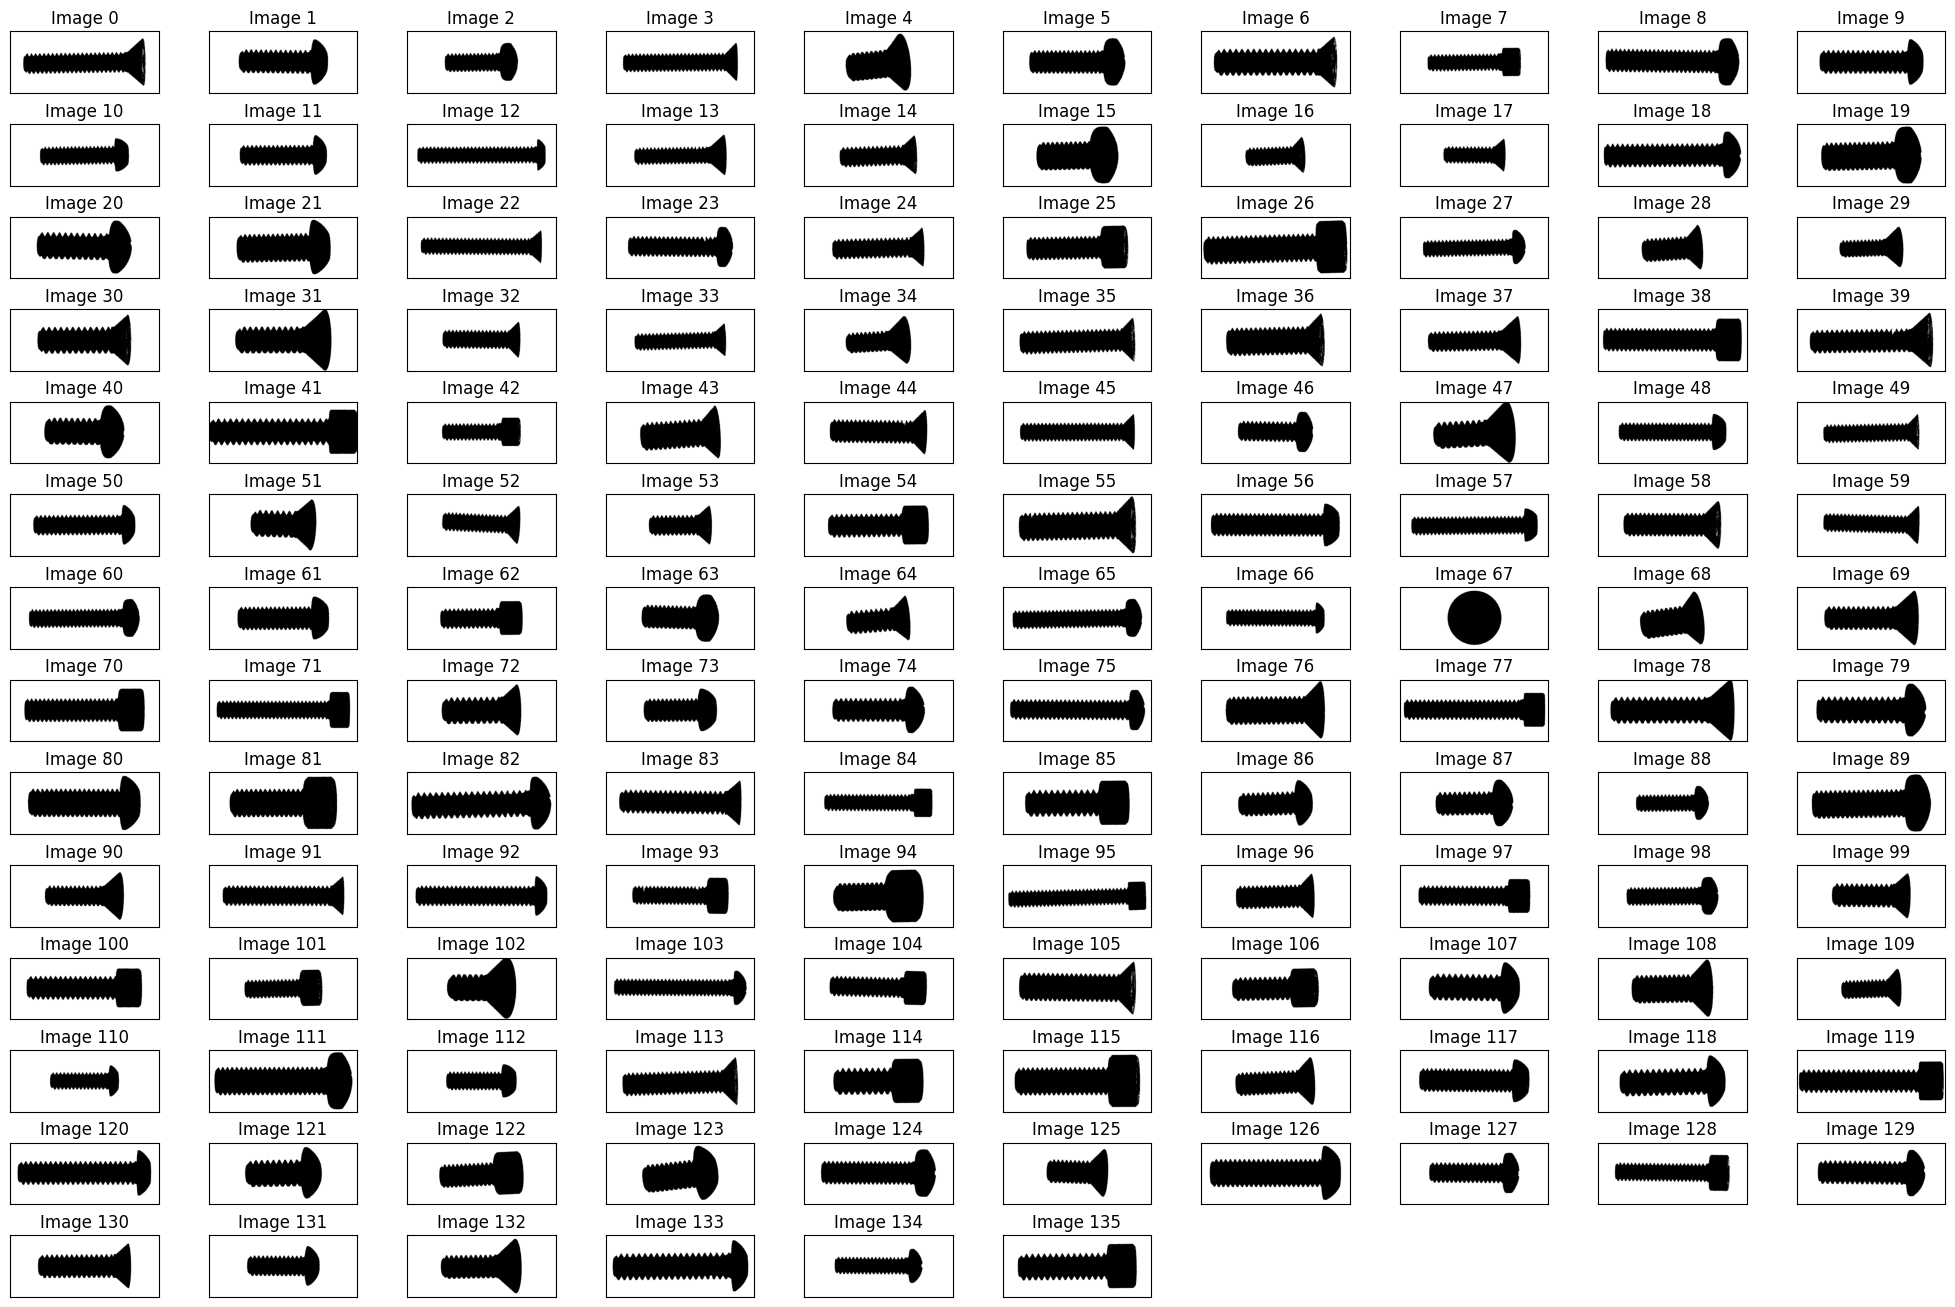

In [10]:
def img_grid(col):
  fig = plt.figure(figsize=(20,15))
  columns = 10
  rows = 16
  for i, img in enumerate(col):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Image {i}".format(i=i))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img, cmap="gray")
  fig.tight_layout()
  return fig

plt.show(img_grid(transformed.iloc[:,0]))

# Classifier Training: Pitch

In [11]:
train_df, test_df = train_test_split(transformed, test_size=0.1, random_state=77)

X_train = train_df["top-down"]
y_train = train_df["pitch"]
X_test = test_df["top-down"]
y_test = test_df["pitch"]

In [12]:
conv_NN = models.Sequential()
conv_NN.add(layers.Conv2D(32, (3,3), activation='relu',           \
                          input_shape=(X_train.iloc[0].shape[0],
                                       X_train.iloc[0].shape[1],
                                       1)))
conv_NN.add(layers.MaxPooling2D((2,2)))
conv_NN.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_NN.add(layers.MaxPooling2D((2,2)))
conv_NN.add(layers.Flatten())
conv_NN.add(layers.Dropout(0.5))
conv_NN.add(layers.Dense(64,activation = 'relu'))
conv_NN.add(layers.Dense(1, activation="linear"))

conv_NN.compile(loss=MeanSquaredError(),
                optimizer='Adam',
                metrics=[Accuracy()])

In [13]:
# TODO: clean this stuff up...
X = np.array([x.reshape(x.shape[0], x.shape[1], 1) for x in X_train.values])
y = y_train.values.astype(np.float64)

X_t = np.array([x.reshape(x.shape[0], x.shape[1], 1) for x in X_test.values])
y_t = y_test.values.astype(np.float64)

ret = conv_NN.fit(X,
                  y,
                  validation_data=(X_t, y_t),
                  epochs=5,
                  batch_size=5)

Epoch 1/5
25/25 [==============================] - 11s 23ms/step - loss: 219.4066 - accuracy: 0.0000e+00 - val_loss: 0.2568 - val_accuracy: 0.0000e+00
Epoch 2/5
25/25 [==============================] - 0s 10ms/step - loss: 0.2397 - accuracy: 0.0000e+00 - val_loss: 0.2556 - val_accuracy: 0.0000e+00
Epoch 3/5
25/25 [==============================] - 0s 10ms/step - loss: 0.2383 - accuracy: 0.0000e+00 - val_loss: 0.2543 - val_accuracy: 0.0000e+00
Epoch 4/5
25/25 [==============================] - 0s 10ms/step - loss: 0.2369 - accuracy: 0.0000e+00 - val_loss: 0.2528 - val_accuracy: 0.0000e+00
Epoch 5/5
25/25 [==============================] - 0s 10ms/step - loss: 0.2353 - accuracy: 0.0000e+00 - val_loss: 0.2510 - val_accuracy: 0.0000e+00


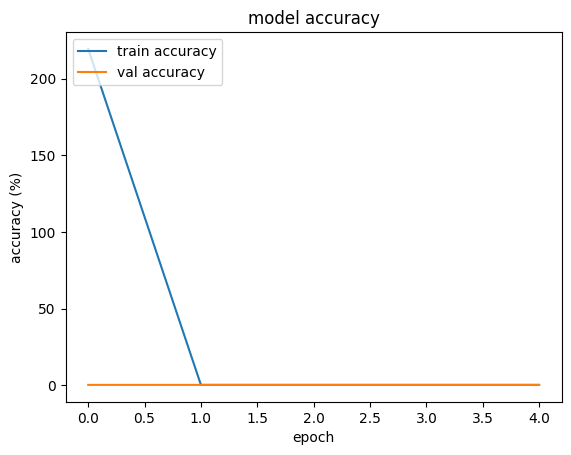

In [14]:
from matplotlib import pyplot as plt

plt.plot(ret.history['loss'])
plt.plot(ret.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [15]:
print(conv_NN.predict(np.array([X_t[10]]))[0])
print(y_t[10])

1/1 [==============================] - 0s 119ms/step
[0.00340227]
0.635


# Old Prototyping Code

In [ ]:
# Debug
i = transformed.iloc[52,0]
i = label_set_persistent.iloc[52,-1]

i_color = cv2.cvtColor(i, cv2.COLOR_GRAY2RGB)
contours,_ = cv2.findContours(i, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
rows,cols = i_color.shape[:2]
[vx,vy,x,y] = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)
vx, vy, x, y = cv2.fitLine(contours_sorted[1], cv2.DIST_L2,0,0.01,0.01)

M = cv2.moments(contours_sorted[1])
x_centroid = int(M['m10']/M['m00'])
y_centroid = int(M['m01']/M['m00'])

print(vx, vy, x, y)
print(type(x[0]))
i_color = cv2.circle(i_color, (int(x[0]),int(y[0])), 1, color=(255,0,0), thickness=-1)
i_color = cv2.circle(i_color, (int(x_centroid),y_centroid), 1, color=(0,255,0), thickness=-1)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
# cv2.line(i_color,(cols-1,righty),(0,lefty),(0,0,255),2)
# print(vx,vy)
# plt.imshow(i_color)
# print(_adjust_vec(vx[0], vy[0], x, y, x_centroid, y_centroid))
# t = i_color[1250:2250,2500:3000]
# SCALE = 20
# new_shape = (t.shape[1]*SCALE, t.shape[0]*SCALE)
# t = cv2.resize(t, new_shape, interpolation= cv2.INTER_LINEAR)

err1 = sys.float_info.max
err2 = sys.float_info.max
p1 = (0,0)
p2 = (0,0)
m = -vy[0]/vx[0]
p0_x = x[0]
p0_y = y[0]

for c in contours_sorted[1]:
  p_x = c[0][0]
  p_y = c[0][1]
  if abs(-(p0_y-p_y)/(p0_x-p_x) - m) < err1 and p_x < p0_x:
    err1 = abs(-(p0_y-p_y)/(p0_x-p_x) - m)
    p1 = (p_x,p_y)
  if abs(-(p_y-p0_y)/(p_x-p0_x) - m) < err2 and p_x > p0_x:
    err2 = abs(-(p_y-p0_y)/(p_x-p0_x) - m)
    p2 = (p_x,p_y)
    pass
  else:
    pass

  # i_color = cv2.circle(i_color, (c[0][0], c[0][1]), 2, color=(0,255,0), thickness=-1)
print(p1,p2)
print(err1, err2)

c = (int((p2[0] + p1[0])/2), int((p2[1] + p1[1])/2))

i_color = cv2.circle(i_color, p1, 2, color=(255,0,0), thickness=-1)
i_color = cv2.circle(i_color, p2, 2, color=(255,0,0), thickness=-1)
i_color = cv2.circle(i_color, c, 2, color=(255,0,0), thickness=-1)

# plt.imshow(i_color[1600:2000,2500:3000])
plt.imshow(i_color)


            width  length     pitch  metric  \
92210A081  2.1844    12.7  0.453571   False   

                                                    top-down  
92210A081  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
<class 'numpy.ndarray'>


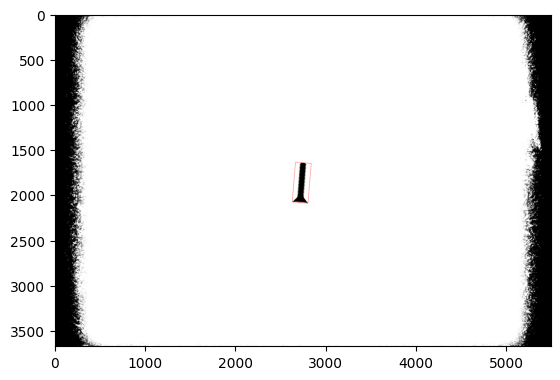

In [ ]:
label_set_persistent.iloc[:1]["top-down"]
print(label_set_persistent.iloc[:1])
label_set_persistent["top-down"].values[0].shape
img = label_set_persistent["top-down"].values[0]
plt.imshow(img, cmap="gray")
print(type(img))
contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
rect = cv2.minAreaRect(contours_sorted[1])
box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
box = np.int0(box)
color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(color_img,[box],0,(255,0,0),2)
plt.imshow(color_img)

In [ ]:
def subimage(image, center, theta, width, height):
   """
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   """
   shape = (image.shape[1], image.shape[0])
   matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=1)
   image = cv2.warpAffine(src=image, M=matrix, dsize=shape)

   w = int(math.ceil(width))
   h = int(math.ceil(height))
   c0 = int(math.ceil(center[0]))
   c1 = int(math.ceil(center[1]))
   x = int(c0 - w/2)
   y = int(c1 - h/2)

   image = image[y:y+h, x:x+w]
   return image

img0 = subimage(img, rect[0], rect[-1], rect[1][0], rect[1][1])
plt.imshow(img0, cmap="gray")

NameError: ignored

In [ ]:
# ct = make_column_transformer(
#     (StandardScaler(), numeric_feats),  # scaling on numeric features
#     (OneHotEncoder(), categorical_feats),  # OHE on categorical features
#     ("passthrough", passthrough_feats),  # no transformations on the binary features
#     ("drop", drop_feats),  # drop the drop features
# )

In [ ]:
os.chdir("/content/drive/MyDrive/2306 Screw Sorter/Experimentation/april-8-imaging-station/fstop/")
# os.chdir("/content/drive/MyDrive/2306 Screw Sorter/Experimentation/april-8-imaging-station/backlight-intensity/55/")

img = cv2.imread('fstop-16-best-focus-50%.tiff', cv2.IMREAD_UNCHANGED)
# img = cv2.imread('big-bolt.tiff', cv2.IMREAD_UNCHANGED)
print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')
plt.imshow(img)
os.chdir("/content")

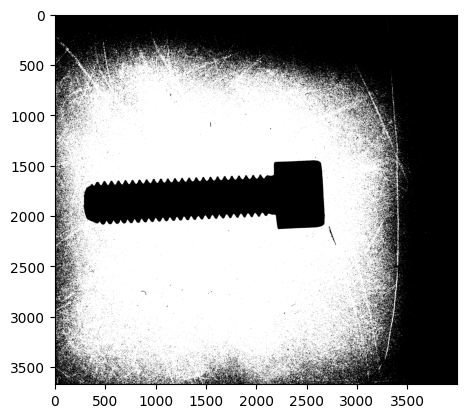

In [ ]:
img0 = img[:,1000:5000]
grey0 = cv2.cvtColor(img0, cv2.COLOR_RGBA2GRAY)
ret,thresh0 = cv2.threshold(grey0,150,255,cv2.THRESH_BINARY)

plt.imshow(thresh0,cmap="gray")

In [ ]:
contours, hierarchy = cv2.findContours(thresh0, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

for c in contours_sorted[0:10]:
    rect = cv2.boundingRect(c)
    if rect[2] < 100 or rect[3] < 100: continue
    print(cv2.contourArea(c))
    x,y,w,h = rect
    color_thresh0 = cv2.cvtColor(thresh0, cv2.COLOR_GRAY2RGB);
    cv2.rectangle(color_thresh0,(x,y),(x+w,y+h),(255,0,0),2)

9566591.5
1047874.0
5989.0


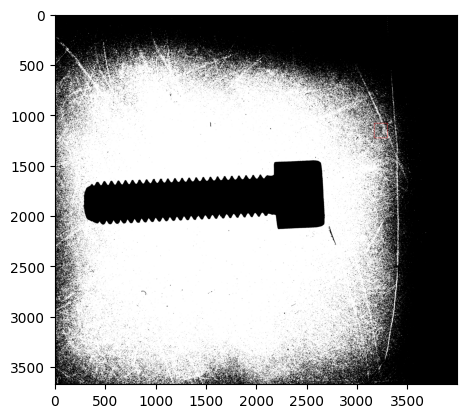

In [ ]:
plt.imshow(color_thresh0)

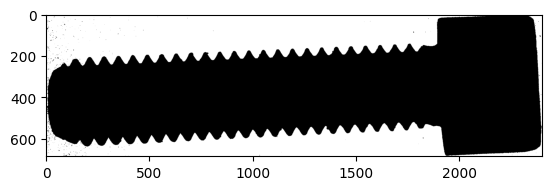

In [ ]:
def resize_shape(scale):
  pass

BUFFER = 0

rect = cv2.boundingRect(contours_sorted[1])
x,y,w,h = rect
screw0 = thresh0[y-BUFFER:y+h+BUFFER,x-BUFFER:x+w+BUFFER]
# SCALE = 4
# new_shape = (screw0.shape[0]*SCALE, screw0.shape[1]*SCALE)
# cv2.resize(screw0, new_shape, interpolation= cv2.INTER_LINEAR)
plt.imshow(screw0, cmap="gray")

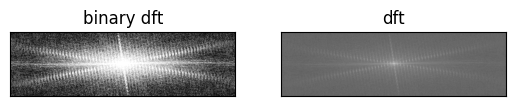

In [ ]:
# find the discrete fourier transform of the image
dft = cv2.dft(np.float32(screw0),flags = cv2.DFT_COMPLEX_OUTPUT)

# shift zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(
      dft_shift[:,:,0],
      dft_shift[:,:,1])
   )

ret,thresh1 = cv2.threshold(magnitude_spectrum,190,255,cv2.THRESH_BINARY)

plt.subplot(121),plt.imshow(thresh1, cmap = 'gray')
plt.title('binary dft'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('dft'), plt.xticks([]), plt.yticks([])
plt.show()

1596 1825
1475 1833


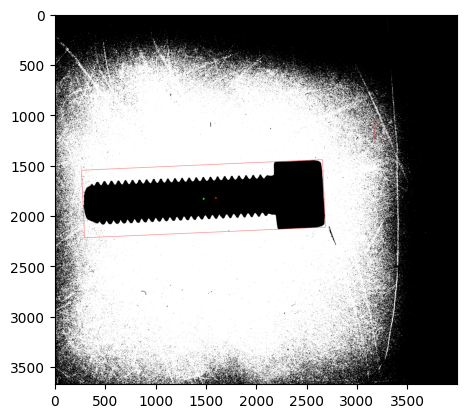

In [ ]:
rect = cv2.minAreaRect(contours_sorted[1])
M = cv2.moments(contours_sorted[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

c0 = int(math.ceil(rect[0][0]))
c1 = int(math.ceil(rect[0][1]))

print(cx, cy)
print(c0, c1)
cv2.circle(color_thresh0, (cx,cy), 10, color=(255,0,0), thickness=-1)
cv2.circle(color_thresh0, (c0,c1), 10, color=(0,255,0), thickness=-1)

box = cv2.boxPoints(rect) # cv2.cv.BoxPoints(rect) for OpenCV <3.x
box = np.int0(box)
cv2.drawContours(color_thresh0,[box],0,(255,0,0),2)
plt.imshow(color_thresh0)
#crop and rotate by min area rect

def normalize_direction(x_center, y_center, x_centroid, y_centroid, theta_curr):
  theta_correction = 0.0
  switch_crop = False
  if x_centroid > x_center and y_centroid < y_center:
    theta_correction = -(90.0 - theta_curr)
    switch_crop = True
  elif x_centroid < x_center and y_centroid < y_center:
    theta_correction = (180 + theta_curr)
  elif x_centroid < x_center and y_centroid > y_center:
    theta_correction = (180-(90-theta_curr))
    switch_crop = True
  else:
    theta_correction = (theta_curr)
  return (theta_correction, switch_crop)

(1474.0643310546875, 1832.890380859375)
87.47917175292969
2393.455078125
671.2743530273438


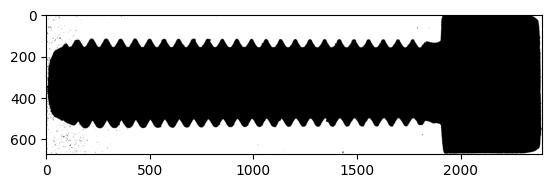

In [ ]:
def subimage(image, center, theta, width, height):

   '''
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   '''
   # Uncomment for theta in radians
   #theta *= 180/np.pi

   w = int(math.ceil(width))
   h = int(math.ceil(height))
   c0 = int(math.ceil(center[0]))
   c1 = int(math.ceil(center[1]))
   x = int(c0 - w/2)
   y = int(c1 - h/2)

   n = normalize_direction(c0, c1, cx, cy, theta)

   shape = (image.shape[1], image.shape[0]) # cv2.warpAffine expects shape in (length, height)
   matrix = cv2.getRotationMatrix2D(center=center, angle=n[0], scale=1)
   image = cv2.warpAffine(src=image, M=matrix, dsize=shape)

   if n[-1]:
    dy = int(w/2)
    dx = int(h/2)
    image = image[c1-dy:c1+dy, c0-dx:c0+dx]
   else:
    image = image[y:y+h, x:x+w]
   return image

test0 = thresh0
test1 = subimage(test0, rect[0], rect[-1], rect[1][0], rect[1][1])
print(rect[0])
print(rect[-1])
print(rect[1][1])
print(rect[1][0])
plt.imshow(test1, cmap="gray")

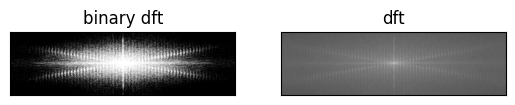

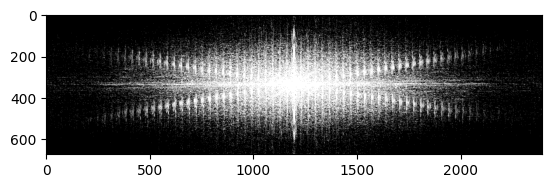

In [ ]:
# find the discrete fourier transform of the image
dft = cv2.dft(np.float32(test1),flags = cv2.DFT_COMPLEX_OUTPUT)

# shift zero-frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(
      dft_shift[:,:,0],
      dft_shift[:,:,1])
   )

ret,thresh1 = cv2.threshold(magnitude_spectrum,190,255,cv2.THRESH_BINARY)

plt.subplot(121),plt.imshow(thresh1, cmap = 'gray')
plt.title('binary dft'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('dft'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(thresh1, cmap="gray")

In [ ]:
borderoutput = cv2.copyMakeBorder(
    test1, 0, 0, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
plt.imshow(borderoutput, cmap="gray")

NameError: ignored